<a href="https://colab.research.google.com/github/Poojav21/Yoga_Pose_Detection/blob/main/Yoga_Pose_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install -q mediapipe

In [14]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

Processing image: istockphoto-639594516-612x612.jpg
Image: istockphoto-639594516-612x612.jpg - Detected Pose: Left Stretching


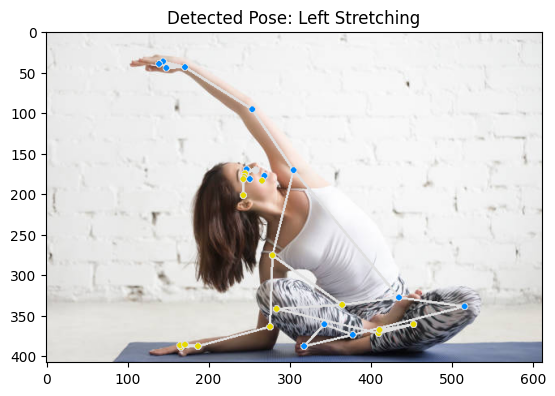

Skipped non-image file: .ipynb_checkpoints


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import zipfile

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)
    if pose_landmarks:
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks.landmark
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

def calculateAngle(landmark1, landmark2, landmark3):
    p1 = np.array([landmark1.x, landmark1.y])
    p2 = np.array([landmark2.x, landmark2.y])
    p3 = np.array([landmark3.x, landmark3.y])
    angle = np.arccos(np.clip(np.dot(p1 - p2, p3 - p2) / (np.linalg.norm(p1 - p2) * np.linalg.norm(p3 - p2)), -1.0, 1.0))
    return np.degrees(angle)

def pose_recognition(results):
    if not results.pose_landmarks:
        return "No Pose Detected"

    left_elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW]
    right_elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]

    left_angle = calculateAngle(left_elbow, results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER], results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP])
    right_angle = calculateAngle(right_elbow, results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER], results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP])

    if left_angle > right_angle:
        return "Left Stretching"
    else:
        return "Right Stretching"

def process_images_in_folder(folder_path, output_folder_path):
    os.makedirs(output_folder_path, exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            print(f"Processing image: {filename}")
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
                results = pose.process(image_rgb)

            pose_type = pose_recognition(results)
            print(f"Image: {filename} - Detected Pose: {pose_type}")

            # Draw landmarks on the image if pose is detected
            if results.pose_landmarks:
                annotated_image = draw_landmarks_on_image(image_rgb, results)
                annotated_image_bgr = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
                output_path = os.path.join(output_folder_path, f"annotated_{filename}")
                cv2.imwrite(output_path, annotated_image_bgr)  # Save annotated image
                plt.imshow(annotated_image)
                plt.title(f"Detected Pose: {pose_type}")
                # plt.axis('off')
                plt.show()
            else:
                plt.imshow(image_rgb)
                plt.title(f"Image: {filename} - No Pose Detected")
                plt.axis('off')
                plt.show()
        else:
            print(f"Skipped non-image file: {filename}")

# Paths
folder_path = '/content/yoga_pose_classification_dataset'
output_folder_path = '/content/processed_images'

# Process all images in the specified folder
process_images_in_folder(folder_path, output_folder_path)


